# Assess Performance of the Error Bars
Measure how many replicas are needed and the quality of the error bars

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import cm
import uncertainty_toolbox.metrics as umetrics
from uncertainty_toolbox.metrics_calibration import (
    get_proportion_lists_vectorized,
)
from uncertainty_toolbox.recalibration import optimize_recalibration_ratio
from itertools import combinations
from scipy.stats import kendalltau, norm
from random import sample
from glob import glob
from tqdm import tqdm
import pandas as pd
import numpy as np
import json
import os

## Load All of the Predictions
Get the `test_results.csv` file, which reports the performance on the model on some hold-out data

In [2]:
outputs = glob(os.path.join('networks', '**', 'test_results.csv'))
print(f'Found {len(outputs)} runs')

Found 16 runs


In [3]:
def load_data(path) -> dict:
    """Get the true, predicted values and random seed"""
    run_data = pd.read_csv(path)
    with open(os.path.join(os.path.dirname(path), 'config.json')) as fp:
        seed = json.load(fp)['random_seed']
    return {
        'true': run_data['true'].values,
        'pred': run_data['pred'].values,
        'seed': seed
    }

In [4]:
run_data = [load_data(p) for p in outputs]

In [5]:
data = {'true': run_data[0]['true']}
for v in run_data:
    data[f'pred-{v["seed"]}'] = v['pred']
data = pd.DataFrame(data)

## Determine How Many Replicas Are Needed
Measure the error bar using all replicas and then see how well the error bars computed with fewer replicas measure up.

In [6]:
pred_cols = [c for c in data.columns if c.startswith('pred-')]

In [7]:
all_std = data[pred_cols].std(axis=1)

Compute the ranking correlation coefficient with different subsets of all of the columns

In [8]:
subset_results = []
for n in tqdm(range(2, len(pred_cols)+1)):
    taus = []
    for c in combinations(pred_cols, n):
        taus.append(kendalltau(all_std, data[list(c)].std(axis=1)).correlation)
    subset_results.append({
        'n': n,
        'count': len(taus),
        'mean': np.mean(taus),
        'median': np.percentile(taus, 50),
        '25perc': np.percentile(taus, 25),
        'std': np.std(taus)
    })

100%|██████████| 15/15 [11:11<00:00, 44.78s/it]


In [9]:
subset_results = pd.DataFrame(subset_results)

Text(0, 0.5, 'Correlation w/ Full Set')

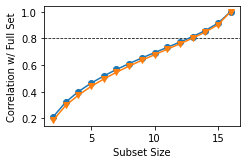

In [10]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

ax.plot(subset_results['n'], subset_results['mean'], 'o-')
ax.plot(subset_results['n'], subset_results['25perc'], 'v-')

ax.set_xlim(ax.get_xlim())
ax.plot(ax.get_xlim(), [0.8]*2, 'k--', zorder=-1, lw=0.75)

ax.set_xlabel('Subset Size')
ax.set_ylabel('Correlation w/ Full Set')

In [11]:
best_n = subset_results.query('mean>0.8')['n'].min()
print(f'Requires {best_n} to achieve a tau of 0.8 with full ensemble')

Requires 13 to achieve a tau of 0.8 with full ensemble


Finding: The ensemble requires at least 12 members. Which is about a 25% savings over the full ensemble. I don't view it as being worthwhile decrease for the decrease in ranking accuracy

## Assess Error Bar Quality
We compare the normalized error to the unit normal distribution. I'm not _really_ sure if this is true, 
but the idea is that if we assume the true value is described by a distribution with mean equal to the ensemble mean
and standard devation equal to the ensemble standard deviation then the normalized error $(y_{pred} - y_{true})/\sigma$ should
be a unit normal distribution

In [12]:
subset_results = []
for n in tqdm(range(2, len(pred_cols)+1)):
    mis = []
    rec = []
    combs = list(combinations(pred_cols, n))
    for c in sample(combs, k=min(16, len(combs))):
        # Summarize the results
        subset = data[list(c)].values
        mean = subset.mean(axis=1)
        std = subset.std(axis=1)
        
        # Get a recalibration factor
        recal_ratio = optimize_recalibration_ratio(mean, std, data['true'].values)
        rec.append(recal_ratio)
        
        # Compute the miscalbiration ratio
        mis.append(umetrics.miscalibration_area(mean, std * recal_ratio, data['true'].values))
    subset_results.append({
        'n': n,
        'count': len(mis),
        'mean': np.mean(mis),
        'mean_recal': np.mean(recal_ratio),
        'median': np.percentile(mis, 50),
        '25perc': np.percentile(mis, 75),
        'std': np.std(mis)
    })

100%|██████████| 15/15 [1:37:47<00:00, 391.17s/it]


In [13]:
subset_results = pd.DataFrame(subset_results)
subset_results.to_csv('calibration-results.csv', index=False)

Text(0, 0.5, 'Miscalibration Area')

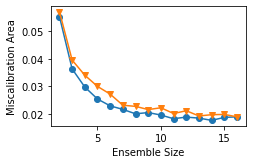

In [14]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

ax.plot(subset_results['n'], subset_results['mean'], 'o-')
ax.plot(subset_results['n'], subset_results['25perc'], 'v-')

ax.set_xlim(ax.get_xlim())

ax.set_xlabel('Ensemble Size')
ax.set_ylabel('Miscalibration Area')

Make a few plots of the full calibration curve

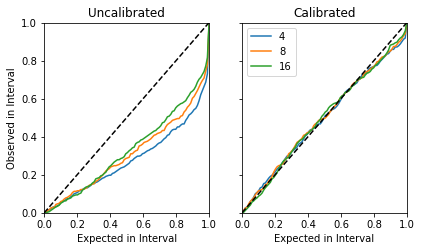

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(6.5, 3.5), sharey=True)

for n in [4, 8, 16]:
     # Summarize the results
    subset = data[sample(c, k=n)].values
    mean = subset.mean(axis=1)
    std = subset.std(axis=1)
    
    # Plot uncalibrated
    exp_props, obs_props = get_proportion_lists_vectorized(mean, std, data['true'].values)
    axs[0].plot(exp_props, obs_props, label=n)

    # Get a recalibration factor
    recal_ratio = optimize_recalibration_ratio(mean, std, data['true'].values)
    exp_props, obs_props = get_proportion_lists_vectorized(mean, std * recal_ratio, data['true'].values)

    axs[1].plot(exp_props, obs_props, label=n)
      

axs[0].set_title('Uncalibrated')
axs[1].set_title('Calibrated')
for ax in axs:
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])
    ax.plot([0, 1], [0, 1], 'k--')
    ax.set_xlabel('Expected in Interval')
axs[0].set_ylabel('Observed in Interval')
    
ax.legend()

*Finding*: Good calibration overall regardless of ensemble size, as long as we scale it appropriately.

## Determine MAE
Do the predictions get better after a certain stage?

In [16]:
subset_results = []
for n in tqdm(range(1, len(pred_cols)+1)):
    maes = []
    for c in combinations(pred_cols, n):
        maes.append(np.abs(data['true'] - data[list(c)].mean(axis=1)).mean())
    subset_results.append({
        'n': n,
        'count': len(maes),
        'mean': np.mean(maes),
        'median': np.percentile(maes, 50),
        '25perc': np.percentile(maes, 75),
        'std': np.std(maes)
    })

100%|██████████| 16/16 [09:54<00:00, 37.13s/it]


In [17]:
subset_results = pd.DataFrame(subset_results)

Text(0, 0.5, 'MAE (V)')

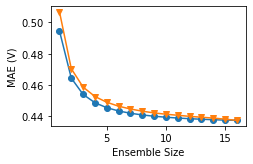

In [18]:
fig, ax = plt.subplots(figsize=(3.5, 2.2))

ax.plot(subset_results['n'], subset_results['mean'], 'o-')
ax.plot(subset_results['n'], subset_results['25perc'], 'v-')

ax.set_xlim(ax.get_xlim())

ax.set_xlabel('Ensemble Size')
ax.set_ylabel('MAE (V)')

*Finding*: Increasing the number of points can be pretty important